In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


## 1. Daten laden & Überblick (MINST‑1 / Intro)

- Laden des **MNIST** Datasets aus Keras
- Überblick über **Shapes** und Wertebereich


In [50]:
# 1.1 Laden
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("x_train shape:", x_train.shape)  # (60000, 28, 28)
print("y_train shape:", y_train.shape)  # (60000,)
print("x_test shape:", x_test.shape)    # (10000, 28, 28)
print("y_test shape:", y_test.shape)    # (10000,)

print("Pixelwert-Min/Max Train:", x_train.min(), x_train.max())


x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
Pixelwert-Min/Max Train: 0 255


## 1.2 DataFrame aus den Trainingsbildern

Jede **Zeile** entspricht **einem Bild** (28×28 → **784** Spalten).
Dieser Schritt dient dem Verständnis für `pd.DataFrame`.


In [51]:
# In (n, 784) bringen – jedes Bild wird "geflattet"
n_train = x_train.shape[0]
x_train_flat = x_train.reshape(n_train, -1)  # (60000, 784)

df_train = pd.DataFrame(x_train_flat)
df_train.head()


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.3 Beispielbild anzeigen

Wir zeigen die Ziffer an **Position 0** in `x_train`.


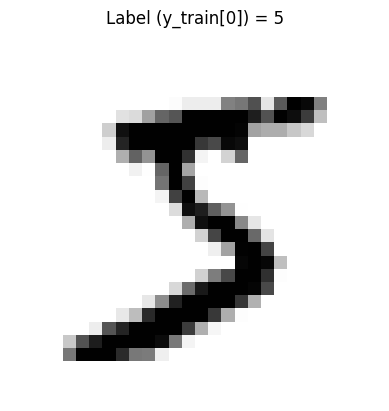

In [52]:
plt.imshow(x_train[0], cmap="gray_r")
plt.title(f"Label (y_train[0]) = {y_train[0]}")
plt.axis("off")
plt.show()


## Vorbereitung für das Modell

- Bilder von (28, 28) → **(784,)** flatten
- Pixelwerte von **0–255** → **0–1** normalisieren
- Labels **One‑Hot** kodieren


In [53]:
# Bilder normalisieren & flatten
x_train_norm = (x_train.astype("float32") / 255.0).reshape(-1, 28*28)
x_test_norm  = (x_test.astype("float32")  / 255.0).reshape(-1, 28*28)

# One-Hot Kodierung der Labels
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

x_train_norm.shape, y_train_cat.shape, x_test_norm.shape, y_test_cat.shape


((60000, 784), (60000, 10), (10000, 784), (10000, 10))

## 1.4 Warum **10** Knoten im Output‑Layer?

Wir klassifizieren handgeschriebene **Ziffern 0–9** → **10** mögliche Klassen.
Der Output‑Layer gibt mit **Softmax** für jede Klasse eine **Wahrscheinlichkeit** zurück, die sich zu **1** summieren.


## 1.5 Modell implementieren & kompilieren

Architektur (gemäß Angabe):

```python
model = Sequential()
model.add(Dense(64, activation="relu", input_shape=(784,)))
model.add(Dense(10, activation="softmax"))
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
```


In [54]:
model = Sequential()
model.add(Dense(64, activation="relu", input_shape=(784,)))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

## 1.6 Training (mit Validation vorbereitet)

- Training gemäß Beispiel (z. B. **epochs=5**, **batch_size=128**)
- Zusätzlich direkt **Validation** übergeben (für **MINST‑2** Plots)


In [55]:
EPOCHS = 20
BATCH_SIZE = 128

history = model.fit(
    x_train_norm, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test_norm, y_test_cat),
    verbose=1
)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8964 - loss: 0.3875 - val_accuracy: 0.9316 - val_loss: 0.2406
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.9410 - loss: 0.2077 - val_accuracy: 0.9463 - val_loss: 0.1803
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.9538 - loss: 0.1599 - val_accuracy: 0.9562 - val_loss: 0.1483
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.9620 - loss: 0.1306 - val_accuracy: 0.9603 - val_loss: 0.1362
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.9680 - loss: 0.1109 - val_accuracy: 0.9654 - val_loss: 0.1179
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.9715 - loss: 0.0968 - val_accuracy: 0.9677 - val_loss: 0.1089
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.9755 - loss: 0.0850 - val_accuracy: 0.9689 - val_loss: 0.1062
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.9779 - loss: 0.0765 - 

## 1.7 Evaluation auf Testdaten


In [56]:
test_loss, test_acc = model.evaluate(x_test_norm, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0821 | Test Accuracy: 0.9776


## Bonus: Beispielvorhersage


In [57]:
probs = model.predict(x_test_norm[:5])
preds = np.argmax(probs, axis=1)
list(zip(preds, y_test[:5]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[(np.int64(7), np.uint8(7)),
 (np.int64(2), np.uint8(2)),
 (np.int64(1), np.uint8(1)),
 (np.int64(0), np.uint8(0)),
 (np.int64(4), np.uint8(4))]

# MINST‑2 Kernauswertung

## 18.2.1 Accuracy‑Plot (Training)


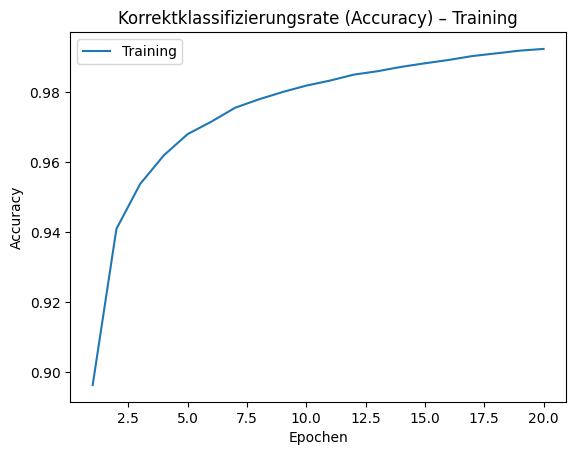

In [58]:
acc = history.history.get("accuracy", [])
plt.figure()
plt.plot(range(1, len(acc)+1), acc, label="Training")
plt.title("Korrektklassifizierungsrate (Accuracy) – Training")
plt.xlabel("Epochen")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## 18.2.2 Accuracy‑Plot (Training vs. Validation)


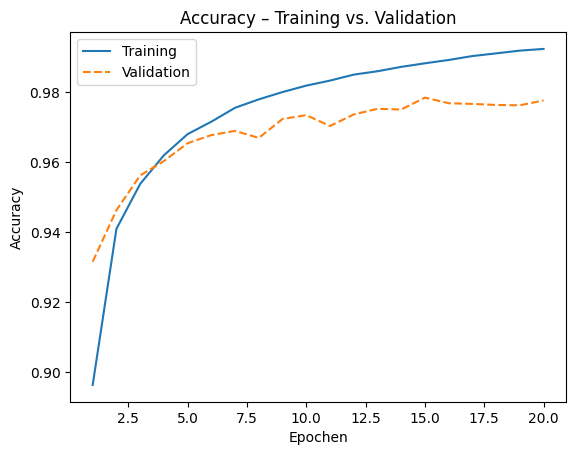

In [59]:
val_acc = history.history.get("val_accuracy", [])
plt.figure()
plt.plot(range(1, len(acc)+1), acc, label="Training")
plt.plot(range(1, len(val_acc)+1), val_acc, linestyle="--", label="Validation")
plt.title("Accuracy – Training vs. Validation")
plt.xlabel("Epochen")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## 18.2.3 Verlustfunktion (Loss) – Training vs. Validation

> Experimentiere lokal mit `EPOCHS` und `BATCH_SIZE`, sodass die Kurven möglichst gut **konvergieren**.


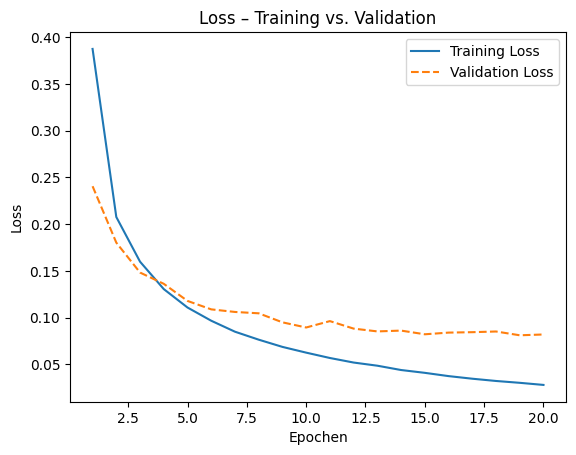

In [60]:
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])
plt.figure()
plt.plot(range(1, len(loss)+1), loss, label="Training Loss")
plt.plot(range(1, len(val_loss)+1), val_loss, linestyle="--", label="Validation Loss")
plt.title("Loss – Training vs. Validation")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.legend()
plt.show()


## 18.2.4 Modell speichern & laden


In [61]:
# Speichern
MODEL_PATH = "mnist_dense_model.keras"  # Keras v3 Format
model.save(MODEL_PATH)
print("Gespeichert unter:", MODEL_PATH)

# Laden (Beispiel)
loaded = load_model(MODEL_PATH)
loss2, acc2 = loaded.evaluate(x_test_norm, y_test_cat, verbose=0)
print(f"Geladenes Modell – Test Accuracy: {acc2:.4f}")


Gespeichert unter: mnist_dense_model.keras
Geladenes Modell – Test Accuracy: 0.9776
